In [ ]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

In [ ]:
!pip install -U scikit-survival

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [ ]:
# Read datasets needed
from google.colab import files 
uploaded = files.upload()

Saving 0227_X_y_imputed_whole.csv to 0227_X_y_imputed_whole.csv


In [ ]:
import io
feature_and_target = pd.read_csv(io.BytesIO(uploaded['0227_X_y_imputed_whole.csv'])) 

In [ ]:
feature_and_target.drop('Unnamed: 0', axis = 1, inplace = True)
feature_and_target

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,mean_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory,time_opt,status_opt
0,348.0,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,70.157760,53.040000,120.033333,1.840796,38.250000,4.000000,4.000000,4.00,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.0,4.000000,4.000000,8.000000,14.250000,12.000000,-0.497512,0.000000,0.000000,0.000000,0.497512,0.000000,-0.497512,-0.497512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000,13.18,0
1,533.0,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,79.560000,51.000000,-0.167224,36.666667,1.000000,1.333333,2.00,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.0,4.000000,4.000000,3.000000,21.333333,11.000000,-0.334448,-0.334448,-0.334448,0.000000,0.000000,0.000000,-0.334448,0.000000,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000,9.44,1
2,902.0,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,58.204386,62.220000,-0.602007,40.250000,4.000000,3.750000,3.25,4.000000,4.00,2.750000,4.000000,2.500000,1.000000,3.0,4.000000,4.000000,7.250000,18.250000,11.000000,-1.086957,0.000000,0.000000,0.362319,0.000000,0.000000,-0.724638,0.000000,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319,5.06,0
3,1736.0,5.0,1.0,-16.800000,-18.739726,0.0,1.939726,71.000000,58.400000,121.400000,-1.280075,24.500000,2.500000,3.000000,3.00,1.500000,1.00,1.000000,0.500000,0.500000,0.000000,3.5,4.000000,4.000000,5.500000,4.500000,11.500000,-3.164557,-0.632911,-1.265823,0.000000,-0.632911,0.000000,0.000000,-0.632911,-0.632911,0.000000,0.632911,0.000000,0.000000,-0.632911,-1.898734,0.632911,8.02,1
4,3971.0,8.0,0.0,-12.427397,-25.084932,0.0,12.657534,86.000000,53.040000,88.900000,-1.250000,38.000000,4.000000,4.000000,4.00,4.000000,4.00,2.000000,3.000000,1.000000,0.000000,4.0,4.000000,4.000000,8.000000,14.000000,12.000000,-0.896762,-0.054849,-0.041205,-0.040174,-0.084564,-0.114611,-0.118540,-0.099158,-0.080400,-0.133462,-0.067174,-0.043216,-0.019409,-0.095040,-0.630737,-0.129774,12.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,998542.0,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,53.040000,72.400000,0.869153,35.500000,4.000000,3.000000,4.00,4.000000,3.00,2.000000,2.000000,2.000000,1.000000,2.5,4.000000,4.000000,8.000000,14.000000,10.500000,-0.896782,-0.054966,-0.041040,-0.040192,-0.084641,-0.114825,-0.118571,-0.098882,-0.080372,-0.133328,-0.067473,-0.042912,-0.019622,-0.095156,-0.630606,-0.129981,0.26,0
2823,998756.0,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,88.400000,70.200000,-3.461413,34.000000,2.666667,2.666667,3.00,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.0,2.000000,2.666667,5.666667,19.000000,6.666667,0.534759,0.000000,-0.534759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519,2.10,0
2824,999166.0,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,83.980000,84.750000,0.871275,43.000000,3.000000,3.000000,4.00,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.0,4.000000,4.000000,7.000000,21.000000,12.000000,-0.897026,-0.054800,-0.041330,-0.039904,-0.084610,-0.114890,-0.118634,-0.099186,-0.080250,-0.133307,-0.067

In [ ]:
# Check the proportion of censored data
event_distribution = pd.DataFrame(feature_and_target[['status_opt']].value_counts()).reset_index()
event_distribution.columns = ['status', 'count']
event_distribution['status'] = event_distribution['status'].astype('bool')
event_distribution = event_distribution.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)   # 2198 censored, 629 uncensored  (78% censored)

         status  count
0  0 (censored)   2198
1   1 (occured)    629


In [ ]:
df_for_featsel = feature_and_target.copy()
df_for_featsel.drop('SubjectID', axis = 1, inplace = True)

In [ ]:
df_for_featsel

,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,mean_fvc,mean_Creatinine,mean_weight,slope_weight,mean_ALSFRS_R_Total,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_R1_Dyspnea,mean_R2_Orthopnea,mean_R3_Respiratory_Insufficiency,mean_bulbar,mean_motor,mean_respiratory,slope_ALSFRS_R_Total,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory,time_opt,status_opt
0,7.0,0.0,-9.928767,-16.471233,0.0,6.542466,70.157760,53.040000,120.033333,1.840796,38.250000,4.000000,4.000000,4.00,3.500000,2.00,2.250000,3.500000,2.000000,1.000000,4.0,4.000000,4.000000,8.000000,14.250000,12.000000,-0.497512,0.000000,0.000000,0.000000,0.497512,0.000000,-0.497512,-0.497512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497512,0.000000,13.18,0
1,10.0,0.0,-1.446575,-33.632877,1.0,32.186301,73.500000,79.560000,51.000000,-0.167224,36.666667,1.000000,1.333333,2.00,4.000000,4.00,3.333333,4.000000,3.333333,2.666667,3.0,4.000000,4.000000,3.000000,21.333333,11.000000,-0.334448,-0.334448,-0.334448,0.000000,0.000000,0.000000,-0.334448,0.000000,0.334448,0.334448,0.000000,0.000000,0.000000,-0.334448,0.334448,0.000000,9.44,1
2,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,89.600000,58.204386,62.220000,-0.602007,40.250000,4.000000,3.750000,3.25,4.000000,4.00,2.750000,4.000000,2.500000,1.000000,3.0,4.000000,4.000000,7.250000,18.250000,11.000000,-1.086957,0.000000,0.000000,0.362319,0.000000,0.000000,-0.724638,0.000000,-0.362319,0.000000,-0.362319,0.000000,0.000000,0.362319,-1.086957,-0.362319,5.06,0
3,5.0,1.0,-16.800000,-18.739726,0.0,1.939726,71.000000,58.400000,121.400000,-1.280075,24.500000,2.500000,3.000000,3.00,1.500000,1.00,1.000000,0.500000,0.500000,0.000000,3.5,4.000000,4.000000,5.500000,4.500000,11.500000,-3.164557,-0.632911,-1.265823,0.000000,-0.632911,0.000000,0.000000,-0.632911,-0.632911,0.000000,0.632911,0.000000,0.000000,-0.632911,-1.898734,0.632911,8.02,1
4,8.0,0.0,-12.427397,-25.084932,0.0,12.657534,86.000000,53.040000,88.900000,-1.250000,38.000000,4.000000,4.000000,4.00,4.000000,4.00,2.000000,3.000000,1.000000,0.000000,4.0,4.000000,4.000000,8.000000,14.000000,12.000000,-0.896762,-0.054849,-0.041205,-0.040174,-0.084564,-0.114611,-0.118540,-0.099158,-0.080400,-0.133462,-0.067174,-0.043216,-0.019409,-0.095040,-0.630737,-0.129774,12.43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822,11.0,1.0,-2.400000,-9.435616,0.0,7.035616,85.000000,53.040000,72.400000,0.869153,35.500000,4.000000,3.000000,4.00,4.000000,3.00,2.000000,2.000000,2.000000,1.000000,2.5,4.000000,4.000000,8.000000,14.000000,10.500000,-0.896782,-0.054966,-0.041040,-0.040192,-0.084641,-0.114825,-0.118571,-0.098882,-0.080372,-0.133328,-0.067473,-0.042912,-0.019622,-0.095156,-0.630606,-0.129981,0.26,0
2823,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,73.333333,88.400000,70.200000,-3.461413,34.000000,2.666667,2.666667,3.00,3.000000,3.00,3.000000,4.000000,3.000000,3.000000,2.0,2.000000,2.666667,5.666667,19.000000,6.666667,0.534759,0.000000,-0.534759,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.069519,0.000000,0.000000,1.069519,2.10,0
2824,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,75.000000,83.980000,84.750000,0.871275,43.000000,3.000000,3.000000,4.00,4.000000,4.00,4.000000,3.000000,3.000000,3.000000,4.0,4.000000,4.000000,7.000000,21.000000,12.000000,-0.897026,-0.054800,-0.041330,-0.039904,-0.084610,-0.114890,-0.118634,-0.099186,-0.080250,-0.133307,-0.067436,-0.043003,-0.019727,-0.094630,-0.630937,-0.130134,12.82,0
2825,8.0,1.

# 1. Wrapper method

In [ ]:
pip install lifelines

##1-1. AFT

### (1) GridSearchcv with lasso

In [ ]:
# Hyperparameter tuning for lasso
from sklearn.model_selection import GridSearchCV

aft_params ={ 'penalizer': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5, 1],
              'l1_ratio' : [1]  }

In [ ]:
# 주의: 5분 이상 소요
from lifelines import WeibullAFTFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import KFold

X_aft = df_for_featsel.drop(columns = 'time_opt')
y_aft = df_for_featsel['time_opt']

base_class2 = sklearn_adapter(WeibullAFTFitter, event_col = 'status_opt')
aft = base_class2()

grid_cv2 = GridSearchCV(aft, param_grid = aft_params, cv = KFold(n_splits = 3), n_jobs = 1)
grid_cv2.fit(X_aft, y_aft)

/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisabl

     fun: 1.0211321583885364
     jac: array([-1.56409350e-04,  4.40373011e-02, -3.28221471e-02, -1.37709620e-01,
       -1.47137596e-01,  5.95288201e-02,  1.15324583e-02,  3.27598272e-03,
       -5.64990418e-04, -9.98804312e-02, -1.11855118e-01, -9.90703623e-02,
        8.80359307e-02, -9.23905678e-02,  1.19108352e-01,  6.58612344e-02,
        4.61117123e-02, -1.19217603e-01, -1.87467345e-04, -1.76528104e-03,
       -9.80886238e-02,  5.25715153e-02, -1.57375421e-01, -2.20344179e-02,
       -3.31516515e-03, -8.11874372e-04,  3.45775171e-02,  1.39054784e-02,
        1.70126240e-02,  7.31188798e-02,  7.96590573e-02, -1.46154098e-01,
        5.43138504e-02,  7.00968199e-02,  8.51379328e-02, -1.34599804e-01,
        6.69606818e-02,  4.89729663e-02,  2.83328206e-03,  4.39647640e-02,
        4.70611307e-02,  8.18115781e-03,  5.94589937e-06, -4.32376011e-05])
 message: 'Iteration limit exceeded'
    nfev: 519
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([-1.52870566

/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


     fun: 1.0813473072591868
     jac: array([-4.34548956e-01, -5.58175381e-01, -4.70183945e-01, -5.33894065e-01,
        3.94482639e-01, -5.26571756e-01,  2.86221368e-01,  3.17051325e-01,
        2.83359260e-01,  4.89835645e-01, -5.27190119e-01,  4.95647750e-01,
       -5.15014421e-01,  5.15559221e-01,  5.16235780e-01, -5.74240017e-01,
        4.28091689e-01, -5.39750064e-01,  2.69477681e-01, -6.08565664e-01,
        4.95421639e-01,  4.16424270e-01,  4.43843869e-01, -4.52390584e-01,
       -3.42554771e-01,  4.03719760e-01, -5.80055628e-01,  4.30915292e-01,
       -5.89783614e-01,  4.75270450e-01, -5.29881967e-01,  4.57998942e-01,
       -5.34472491e-01, -5.30382665e-01,  4.84885585e-01,  4.76926009e-01,
        4.65991193e-01, -5.42094993e-01,  3.88822143e-01, -5.54047539e-01,
        4.56653844e-01, -5.64800042e-01, -1.73112107e-07, -6.14717772e-01])
 message: 'Iteration limit exceeded'
    nfev: 802
     nit: 201
    njev: 201
  status: 9
 success: False
       x: array([-3.81077166

/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisabl

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SkLearnWeibullAFTFitter(alpha=0.05, fit_intercept=True,
                                               l1_ratio=0.0,
                                               model_ancillary=False,
                                               penalizer=0.0),
             n_jobs=1,
             param_grid={'l1_ratio': [1],
                         'penalizer': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]})

In [ ]:
# Result
print(grid_cv2.best_score_)  # 0.859530314276509
print(grid_cv2.best_params_)  # {'l1_ratio': 1, 'penalizer': 0.01} is selected 

0.859530314276509
{'l1_ratio': 1, 'penalizer': 0.01}


In [ ]:
# Fit model with selected hyperparameter & print summary 
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_for_featsel, duration_col='time_opt', event_col='status_opt', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:2053: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


<lifelines.WeibullAFTFitter: fitted with 2827 total observations, 2198 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
   number of observations = 2827
number of events observed = 629
           log-likelihood = -2491.48
         time fit was run = 2022-02-27 17:50:51 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                  
lambda_ Age                                 -0.05       0.95       0.01            -0.07            -0.04                 0.93                 0.96
        Gender                               0.00       1.00       0.05            -0.10             0.10                 0.91                 1.10
        diag_delta                          -0.01       0.99        NaN              NaN              NaN                  NaN                  NaN
        diag_minus_onset                     0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_ALSFRS_R_Total                  0.00       1.00    5014.71         -9828.65          9828.65                 0.00                  inf
        mean_Creatinine                      0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
        mean_Q1_Speech                       0.00       1.00  107482.67       -210662.16        210662.16                 0.00                  inf
        mean_Q2_Salivation                   0.04       1.04    5014.71         -9828.60          9828.69                 0.00                  inf
        mean_Q3_Swallowing                   0.29       1.33  107482.65       -210661.83        210662.40                 0.00                  inf
        mean_Q4_Handwriting                  0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_Q5_Cutting                      0.03       1.03        NaN              NaN              NaN                  NaN                  NaN
        mean_Q6_Dressing_and_Hygiene        -0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_Q7_Turning_in_Bed               0.06       1.06        NaN              NaN              NaN                  NaN                  NaN
        mean_Q8_Walking                      0.01       1.01        NaN              NaN              NaN                  NaN                  NaN
        mean_Q9_Climbing_Stairs             -0.03       0.97        NaN              NaN              NaN                  NaN                  NaN
        mean_R1_Dyspnea                     -0.03       0.97   69247.42       -135722.48        135722.42                 0.00                  inf
        mean_R2_Orthopnea                    0.00       1.00   69247.42       -135722.44        135722.45                 0.00                  inf
        mean_R3_Respiratory_Insufficiency   -0.03       0.97   69247.42       -135722.48        135722.42                 0.00                  inf
        mean_bulbar                          0.15       1.16  145199.14       -284584.93        284585.22                 0.00                  inf
        mean_fvc                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
        mean_motor                           0.00       1.00    4670.85         -9154.71          9154.71                 0.00                  inf
        mean_respiratory                     0.00       1.00   63998.78       -125435.31        125435.31                 0.00                  inf
        mean_weight                          0.00       1.00       0.00     

In [ ]:
# Features with coefficient = 0 are excluded  (feature selection through lasso)
aft_final_feature_list = ['Age', 'diag_delta', 'onset_delta', 'onset_site',
       'mean_fvc', 
       'slope_weight',
       'mean_Q2_Salivation', 'mean_Q3_Swallowing',
       'mean_Q5_Cutting', 
       'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs',
       'mean_R1_Dyspnea',
       'mean_R3_Respiratory_Insufficiency', 'mean_bulbar', 
       'slope_ALSFRS_R_Total', 
       'slope_Q2_Salivation', 'slope_Q3_Swallowing', 'slope_Q6_Dressing_and_Hygiene',
        'slope_Q8_Walking',
       'slope_R2_Orthopnea',
       'slope_R3_Respiratory_Insufficiency', 'slope_bulbar']

In [ ]:
# Fit model with selected hyperparameter and features & print summary 
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_for_featsel[aft_final_feature_list+['time_opt', 'status_opt']], duration_col='time_opt', event_col='status_opt', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

<lifelines.WeibullAFTFitter: fitted with 2827 total observations, 2198 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
   number of observations = 2827
number of events observed = 629
           log-likelihood = -2495.97
         time fit was run = 2022-02-27 18:34:44 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                  
lambda_ Age                                 -0.06       0.94       0.01            -0.07            -0.04                 0.93                 0.96
        diag_delta                          -0.01       0.99       0.00            -0.02             0.00                 0.98                 1.00
        mean_Q2_Salivation                   0.04       1.04       0.03            -0.02             0.10                 0.98                 1.10
        mean_Q3_Swallowing                   0.29       1.34       0.06             0.18             0.41                 1.20                 1.51
        mean_Q5_Cutting                      0.03       1.03       0.03            -0.02             0.08                 0.98                 1.09
        mean_Q7_Turning_in_Bed               0.06       1.06       0.04            -0.01             0.13                 0.99                 1.14
        mean_Q8_Walking                      0.03       1.03       0.04            -0.06             0.12                 0.94                 1.12
        mean_Q9_Climbing_Stairs             -0.03       0.97       0.03            -0.08             0.03                 0.92                 1.03
        mean_R1_Dyspnea                     -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
        mean_R3_Respiratory_Insufficiency   -0.03       0.97       0.05            -0.12             0.07                 0.88                 1.07
        mean_bulbar                          0.15       1.16       0.03             0.09             0.21                 1.09                 1.23
        mean_fvc                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
        onset_delta                         -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
        onset_site                          -0.10       0.91       0.06            -0.21             0.02                 0.81                 1.02
        slope_ALSFRS_R_Total                 0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
        slope_Q2_Salivation                  0.17       1.19       0.06             0.05             0.29                 1.05                 1.33
        slope_Q3_Swallowing                  0.06       1.06       0.10            -0.13             0.25                 0.88                 1.29
        slope_Q6_Dressing_and_Hygiene        0.20       1.22       0.07             0.06             0.35                 1.06                 1.41
        slope_Q8_Walking                     0.06       1.06       0.09            -0.11             0.22                 0.89                 1.25
        slope_R2_Orthopnea                  -0.01       0.99       0.06            -0.14             0.11                 0.87                 1.12
        slope_R3_Respiratory_Insufficiency   0.20       1.22       0.11            -0.01             0.41                 0.99                 1.50
        slope_bulbar                         0.21       1.24       0.07             0.07             0.36                 1.07                 1.43
        slope_weight                         0.06       1.07       0.01     

##1-2. COX

### (1) GridSearchcv with lasso

In [ ]:
# Hyperparameter tuning for lasso
from sklearn.model_selection import GridSearchCV

cox_params ={'penalizer': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5, 1],
            'l1_ratio' : [1] }

In [ ]:
# 1분 소요
from lifelines import CoxPHFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import KFold

X_cox = df_for_featsel.drop(columns = 'time_opt')
y_cox = df_for_featsel['time_opt']

base_class = sklearn_adapter(CoxPHFitter, event_col = 'status_opt')
cph = base_class()

grid_cv = GridSearchCV(cph, param_grid = cox_params, cv = KFold(n_splits = 3), n_jobs = 1)
grid_cv.fit(X_cox, y_cox)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SkLearnCoxPHFitter(baseline_estimation_method='breslow',
                                          breakpoints=None, knots=None,
                                          l1_ratio=0.0, n_baseline_knots=None,
                                          penalizer=0.0, strata=None),
             n_jobs=1,
             param_grid={'l1_ratio': [1],
                         'penalizer': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]})

In [ ]:
# Result
print(grid_cv.best_score_)  # 0.860664100690076
print(grid_cv.best_params_)  # {'l1_ratio': 1, 'penalizer': 0.01}

0.860664100690076
{'l1_ratio': 1, 'penalizer': 0.01}


In [ ]:
# Fit model with selected hyperparameter & print summary 
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_for_featsel, 'time_opt', event_col='status_opt')
cph.print_summary() # Prints hazard ratio & p-value of each feature

<lifelines.CoxPHFitter: fitted with 2827 total observations, 2198 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 2827
number of events observed = 629
   partial log-likelihood = -4004.42
         time fit was run = 2022-02-27 19:35:08 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
Age                                  0.09       1.09       0.02             0.05             0.13                 1.05                 1.14
Gender                              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
diag_delta                           0.01       1.01       0.01            -0.01             0.02                 0.99                 1.03
onset_delta                          0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
onset_site                           0.15       1.16       0.12            -0.10             0.39                 0.91                 1.48
diag_minus_onset                    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_fvc                            -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
mean_Creatinine                     -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
mean_weight                         -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
slope_weight                        -0.11       0.89       0.02            -0.16            -0.07                 0.85                 0.93
mean_ALSFRS_R_Total                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q1_Speech                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q2_Salivation                  -0.08       0.92       0.06            -0.20             0.04                 0.82                 1.04
mean_Q3_Swallowing                  -0.55       0.58       0.12            -0.79            -0.30                 0.45                 0.74
mean_Q4_Handwriting                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q5_Cutting                     -0.05       0.95       0.05            -0.15             0.05                 0.86                 1.06
mean_Q6_Dressing_and_Hygiene        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q7_Turning_in_Bed              -0.06       0.94       0.07            -0.19             0.07                 0.83                 1.07
mean_Q8_Walking                     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q9_Climbing_Stairs              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_R1_Dyspnea                      0.01       1.01       0.06            -0.12             0.13                 0.89                 1.14
mean_R2_Orthopnea                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_R3_Respiratory_Insufficiency    0.01       1.01       0.10            -0.19             0.21                 0.83                 1.23
mean_bulbar                         -0.33       0.72       0.06    

In [ ]:
# Features with coefficient = 0 are excluded  (feature selection through lasso)
cph_final_feature_list = ['Age', 'diag_delta', 'onset_delta', 'onset_site',
        'mean_fvc', 
       'slope_weight',
       'mean_Q2_Salivation', 'mean_Q3_Swallowing', 
       'mean_Q5_Cutting', 
       'mean_Q7_Turning_in_Bed', 
       'mean_R1_Dyspnea', 
       'mean_R3_Respiratory_Insufficiency', 'mean_bulbar', 'slope_ALSFRS_R_Total', 
       'slope_Q2_Salivation', 'slope_Q3_Swallowing',  'slope_Q6_Dressing_and_Hygiene',
       'slope_Q8_Walking',
        'slope_R2_Orthopnea',
       'slope_R3_Respiratory_Insufficiency', 'slope_bulbar']

In [ ]:
# Fit model with selected hyperparameter and features & print summary 
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_for_featsel[cph_final_feature_list+['time_opt', 'status_opt']], 'time_opt', event_col='status_opt')
cph.print_summary() # Prints hazard ratio & p-value of each feature

<lifelines.CoxPHFitter: fitted with 2827 total observations, 2198 right-censored observations>
             duration col = 'time_opt'
                event col = 'status_opt'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 2827
number of events observed = 629
   partial log-likelihood = -4006.44
         time fit was run = 2022-02-27 19:45:40 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
Age                                  0.09       1.10       0.02             0.06             0.13                 1.06                 1.14
diag_delta                           0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
onset_delta                          0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
onset_site                           0.15       1.16       0.12            -0.09             0.40                 0.91                 1.49
mean_fvc                            -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
slope_weight                        -0.11       0.89       0.02            -0.16            -0.07                 0.85                 0.93
mean_Q2_Salivation                  -0.07       0.93       0.06            -0.19             0.05                 0.82                 1.05
mean_Q3_Swallowing                  -0.56       0.57       0.12            -0.80            -0.32                 0.45                 0.73
mean_Q5_Cutting                     -0.05       0.95       0.05            -0.15             0.06                 0.86                 1.06
mean_Q7_Turning_in_Bed              -0.08       0.93       0.07            -0.20             0.05                 0.82                 1.05
mean_R1_Dyspnea                      0.02       1.02       0.06            -0.10             0.14                 0.90                 1.15
mean_R3_Respiratory_Insufficiency    0.01       1.01       0.10            -0.19             0.20                 0.83                 1.22
mean_bulbar                         -0.33       0.72       0.06            -0.46            -0.21                 0.63                 0.81
slope_ALSFRS_R_Total                -0.05       0.95       0.05            -0.15             0.04                 0.86                 1.04
slope_Q2_Salivation                 -0.26       0.77       0.13            -0.51            -0.01                 0.60                 0.99
slope_Q3_Swallowing                 -0.11       0.89       0.21            -0.52             0.29                 0.60                 1.34
slope_Q6_Dressing_and_Hygiene       -0.32       0.72       0.15            -0.62            -0.02                 0.54                 0.98
slope_Q8_Walking                    -0.12       0.89       0.18            -0.48             0.24                 0.62                 1.28
slope_R2_Orthopnea                   0.02       1.02       0.13            -0.25             0.28                 0.78                 1.32
slope_R3_Respiratory_Insufficiency  -0.22       0.81       0.22            -0.66             0.22                 0.52                 1.25
slope_bulbar                        -0.46       0.63       0.15            -0.76            -0.15                 0.47                 0.86

                                       z      p   -log2(p)
covariate                                                 
Age                                 4.94 <0.005      20.31
diag_delta                          0.72   0.47       1.09
onset_delta                         3.85 <0.005      13.05
onset_site                          1.22   0.22    

##1-3. RSF: Hyparamter tuning -> Permutation importance

### (1) Pre - Hyperparmeter tuning

In [ ]:
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = df_for_featsel.iloc[:, -2:][['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})

In [ ]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 13.18), ( True,  9.44), (False,  5.06), ...,
       (False, 12.82), (False,  6.05), (False,  4.14)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
from sklearn.model_selection import GridSearchCV

params ={ 'n_estimators':[100],
          'max_features':['auto', 'sqrt','log2', None],
          'min_samples_leaf':[10,14,18],
          'min_samples_split':[8,12,16] }

In [ ]:
#30분 소요
from sklearn.model_selection import KFold
rf = RandomSurvivalForest(random_state=20, n_jobs=-1)
grid_cv3 = GridSearchCV(rf, param_grid=params, cv=KFold(n_splits = 2), n_jobs=-1)
GG = grid_cv3.fit(df_for_featsel.iloc[:,:-2], y_train_rsf)

In [ ]:
# Result
print(grid_cv3.best_score_) # 0.863375506939803
print(grid_cv3.best_params_) # {'max_features': 'auto', 'min_samples_leaf': 10 'min_samples_split': 8, 'n_estimators': 100} is selected

0.863375506939803
{'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 100}


### (2) Permutation importance

In [ ]:
pip install eli5

     |████████████████████████████████| 106 kB 5.1 MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
rsf_feature_list = ['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site',
       'diag_minus_onset', 'mean_fvc', 'mean_Creatinine', 'mean_weight',
       'slope_weight', 'mean_ALSFRS_R_Total', 'mean_Q1_Speech',
       'mean_Q2_Salivation', 'mean_Q3_Swallowing', 'mean_Q4_Handwriting',
       'mean_Q5_Cutting', 'mean_Q6_Dressing_and_Hygiene',
       'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs',
       'mean_R1_Dyspnea', 'mean_R2_Orthopnea',
       'mean_R3_Respiratory_Insufficiency', 'mean_bulbar', 'mean_motor',
       'mean_respiratory', 'slope_ALSFRS_R_Total', 'slope_Q1_Speech',
       'slope_Q2_Salivation', 'slope_Q3_Swallowing', 'slope_Q4_Handwriting',
       'slope_Q5_Cutting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs', 'slope_R1_Dyspnea', 'slope_R2_Orthopnea',
       'slope_R3_Respiratory_Insufficiency', 'slope_bulbar', 'slope_motor',
       'slope_respiratory']

In [ ]:
#52초 소요
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=10,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_for_featsel[rsf_feature_list], y_train_rsf)

RandomSurvivalForest(min_samples_leaf=10, min_samples_split=8, n_jobs=-1,
                     random_state=20)

In [ ]:
#3분 50초 소요
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=20)
perm.fit(df_for_featsel[rsf_feature_list], y_train_rsf)

PermutationImportance(estimator=RandomSurvivalForest(min_samples_leaf=10,
                                                     min_samples_split=8,
                                                     n_jobs=-1,
                                                     random_state=20),
                      n_iter=15, random_state=20)

In [ ]:
data = perm.results_
data = pd.DataFrame(data, columns=rsf_feature_list)
means = data.mean()
means = means.sort_values(ascending=False)
data = data[means.index]
data = np.transpose(data)

In [ ]:
means

mean_bulbar                           0.015896
mean_Q3_Swallowing                    0.015041
mean_Q1_Speech                        0.010115
onset_delta                           0.007960
slope_weight                          0.007526
mean_fvc                              0.007516
Age                                   0.006694
mean_ALSFRS_R_Total                   0.006297
onset_site                            0.004995
slope_ALSFRS_R_Total                  0.004868
mean_Q2_Salivation                    0.004135
mean_motor                            0.004008
mean_weight                           0.003936
diag_delta                            0.003582
slope_bulbar                          0.003369
slope_Q1_Speech                       0.003040
mean_Creatinine                       0.002790
mean_Q7_Turning_in_Bed                0.002723
diag_minus_onset                      0.002556
mean_Q5_Cutting                       0.002487
slope_Q2_Salivation                   0.002461
slope_motor  

In [ ]:
rsf_final_feature_list = ['Age', 'diag_delta', 'onset_delta', 'onset_site',  'diag_minus_onset', 'mean_fvc', 'mean_Creatinine',
       'mean_weight', 'slope_weight', 'mean_ALSFRS_R_Total', 'mean_Q1_Speech',  'mean_Q2_Salivation', 'mean_Q3_Swallowing', 
       'mean_Q5_Cutting',  'mean_Q7_Turning_in_Bed',  'mean_bulbar', 'mean_motor','slope_ALSFRS_R_Total', 'slope_Q1_Speech',
        'slope_bulbar']

# 3. Finalize feature selection & hyperparameter tuning

In [ ]:
from matplotlib_venn import venn3_unweighted

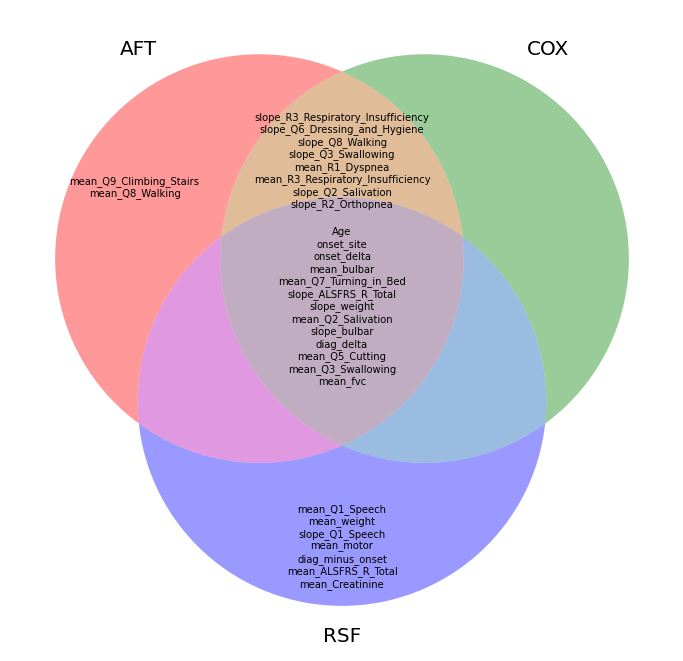

<Figure size 1800x1800 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Define 2 sets
A = set(aft_final_feature_list)
B = set(cph_final_feature_list)
C = set(rsf_final_feature_list)

# Create and instance of a venn diagram with 2 areas
plt.figure(figsize=(12,12))
diagram = venn3_unweighted([A, B, C], ("AFT", "COX", "RSF"))

# Set text content of areas
diagram.get_label_by_id("100").set_text("\n".join(A - B - C))
diagram.get_label_by_id("010").set_text("\n".join(B - A - C))
diagram.get_label_by_id("001").set_text("\n".join(C - B - A))
diagram.get_label_by_id("110").set_text("\n".join(A & B - C))
diagram.get_label_by_id("101").set_text("\n".join(A & C - B))
diagram.get_label_by_id("011").set_text("\n".join(C & B - A))
diagram.get_label_by_id("111").set_text("\n".join(A & B & C))

# Modify font sizes
for text in diagram.set_labels:
    text.set_fontsize(20)
for text in diagram.subset_labels:
    text.set_fontsize(10)

plt.figure(figsize=(25,25))
plt.show()